# 1. EXPLORATION DES DONNEES


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
fifa = pd.read_csv("all_players.csv", index_col=0)
fifa.head()

,Rank,Name,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,...,Nation,League,Team,play style,url,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
0,1,Kylian Mbappé,91,97,90,80,92,36,78,97,...,France,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Acrobatic, Finesse Shot, Flair, R...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
1,2,Rodri,91,66,80,86,84,87,85,65,...,Spain,Premier League,Manchester City,"Tiki Taka+, Aerial, Bruiser, Long Ball Pass, P...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
2,4,Erling Haaland,91,88,92,70,81,45,88,80,...,Norway,Premier League,Manchester City,"Acrobatic+, Bruiser, Power Header, Power Shot,...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
3,5,Jude Bellingham,90,80,87,83,88,78,83,81,...,England,LALIGA EA SPORTS,Real Madrid,"Relentless+, Flair, Intercept, Slide Tackle, T...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN
4,7,Vini Jr.,90,95,84,81,91,29,69,95,...,Brazil,LALIGA EA SPORTS,Real Madrid,"Quick Step+, Chip Shot, Finesse Shot, First To...",https://www.ea.com/games/ea-sports-fc/ratings/...,NaN,NaN,NaN,NaN,NaN


In [3]:
fifa.describe()

,Rank,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,...,Strength,Aggression,Weak foot,Skill moves,Age,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
count,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,...,17737.000000,17737.000000,17737.000000,17737.000000,17737.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,8503.317021,66.796245,68.237921,54.846197,59.152506,64.205728,51.222473,65.420590,64.814343,64.871286,...,65.330270,56.401026,2.947229,2.409201,25.744151,65.882941,63.914457,63.021511,64.393197,66.745373
std,5109.915335,7.030997,10.587756,13.858698,9.826691,9.359164,16.477859,9.468368,15.405388,15.173941,...,12.421711,16.821552,0.678567,0.793737,4.640097,7.541962,7.253951,7.614001,8.296162,7.922466
min,1.000000,47.000000,29.000000,20.000000,25.000000,29.000000,15.000000,32.000000,15.000000,15.000000,...,26.000000,11.000000,1.000000,1.000000,17.000000,45.000000,45.000000,44.000000,41.000000,45.000000
25%,4260.000000,62.000000,62.000000,46.000000,53.000000,59.000000,37.000000,59.000000,57.000000,57.000000,...,58.000000,46.000000,3.000000,2.000000,22.000000,61.000000,59.000000,58.000000,59.000000,61.000000
50%,7937.000000,67.000000,69.000000,57.000000,60.000000,65.000000,55.000000,66.000000,68.000000,68.000000,...,66.000000,60.000000,3.000000,2.000000,25.000000,66.000000,64.000000,62.000000,64.000000,66.000000
75%,13135.000000,71.000000,75.000000,65.000000,66.000000,70.000000,64.000000,72.000000,75.000000,75.000000,...,74.000000,69.000000,3.000000,3.000000,29.000000,71.000000,69.000000,68.000000,70.000000,72.000000
max,17717.000000,91.000000,97.000000,93.000000,94.000000,92.000000,91.000000,91.000000,97.000000,97.000000,...,95.000000,95.000000,5.000000,5.000000,44.000000,90.000000,90.000000,91.000000,90.000000,91.000000


In [4]:
print(fifa.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17737 entries, 0 to 17736
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rank                   17737 non-null  int64  
 1   Name                   17737 non-null  object 
 2   OVR                    17737 non-null  int64  
 3   PAC                    17737 non-null  int64  
 4   SHO                    17737 non-null  int64  
 5   PAS                    17737 non-null  int64  
 6   DRI                    17737 non-null  int64  
 7   DEF                    17737 non-null  int64  
 8   PHY                    17737 non-null  int64  
 9   Acceleration           17737 non-null  int64  
 10  Sprint Speed           17737 non-null  int64  
 11  Positioning            17737 non-null  int64  
 12  Finishing              17737 non-null  int64  
 13  Shot Power             17737 non-null  int64  
 14  Long Shots             17737 non-null  int64  
 15  Volleys

Résumé des valeurs manquantes :
                       Total Manquants  Pourcentage (%)
GK Diving                        15738        88.729774
GK Kicking                       15738        88.729774
GK Handling                      15738        88.729774
GK Positioning                   15738        88.729774
GK Reflexes                      15738        88.729774
play style                        9496        53.537802
Alternative positions             7959        44.872301


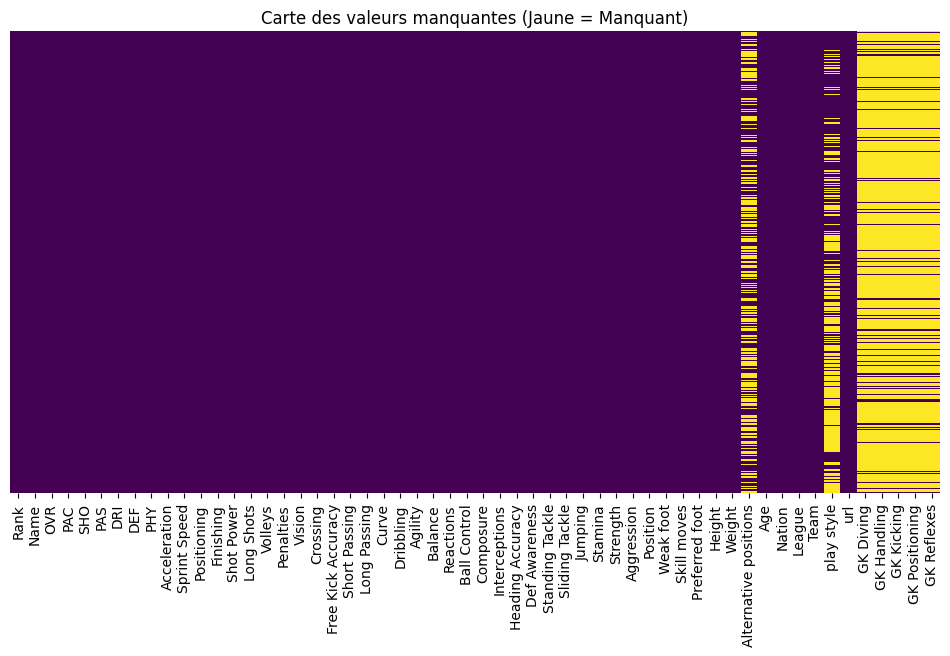

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

missing_data = fifa.isnull().sum()
missing_percentage = (fifa.isnull().sum() / len(fifa)) * 100


missing_df = pd.DataFrame({
    'Total Manquants': missing_data,
    'Pourcentage (%)': missing_percentage
})

missing_df = missing_df[missing_df['Total Manquants'] > 0].sort_values(by='Pourcentage (%)', ascending=False)

print("Résumé des valeurs manquantes :")
print(missing_df)

plt.figure(figsize=(12, 6))
sns.heatmap(fifa.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title('Carte des valeurs manquantes (Jaune = Manquant)')
plt.show()

In [6]:
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


numerical_selector = make_column_selector(dtype_include=['number'])
categorical_selector = make_column_selector(dtype_include=['object', 'category'])

cat_col = categorical_selector(fifa)
num_col = numerical_selector(fifa)

print(cat_col)
print(num_col)


['Name', 'Position', 'Preferred foot', 'Height', 'Weight', 'Alternative positions', 'Nation', 'League', 'Team', 'play style', 'url']
['Rank', 'OVR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY', 'Acceleration', 'Sprint Speed', 'Positioning', 'Finishing', 'Shot Power', 'Long Shots', 'Volleys', 'Penalties', 'Vision', 'Crossing', 'Free Kick Accuracy', 'Short Passing', 'Long Passing', 'Curve', 'Dribbling', 'Agility', 'Balance', 'Reactions', 'Ball Control', 'Composure', 'Interceptions', 'Heading Accuracy', 'Def Awareness', 'Standing Tackle', 'Sliding Tackle', 'Jumping', 'Stamina', 'Strength', 'Aggression', 'Weak foot', 'Skill moves', 'Age', 'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']


/var/folders/lh/9q5zb88s3597k4f9dr4r0zj40000gn/T/ipykernel_60174/1603390757.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Position', data=fifa, order=fifa['Position'].value_counts().index, palette='viridis')


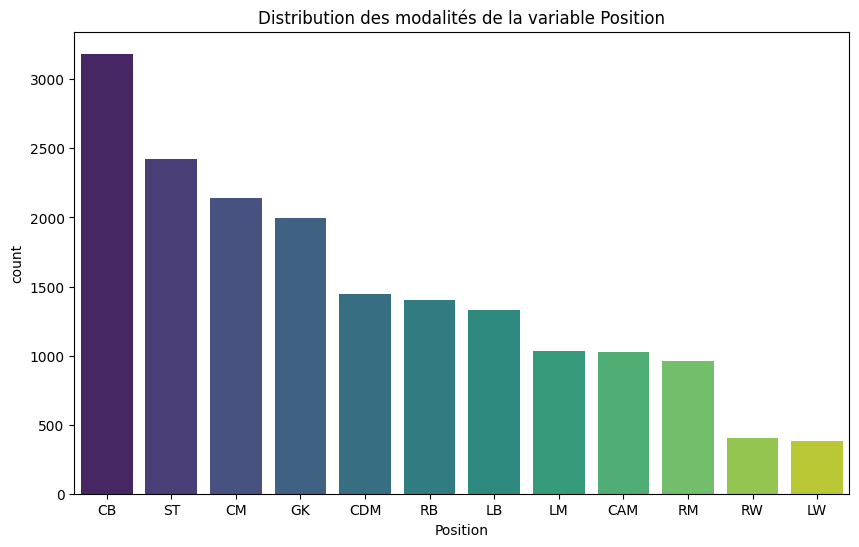

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.countplot(x='Position', data=fifa, order=fifa['Position'].value_counts().index, palette='viridis')
plt.title('Distribution des modalités de la variable Position')
plt.show()

# 2. ANALYSE UNIVARIEE & BIVARIEE


/var/folders/lh/9q5zb88s3597k4f9dr4r0zj40000gn/T/ipykernel_60174/3770494627.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cardinality.values, y=cardinality.index, palette=colors)


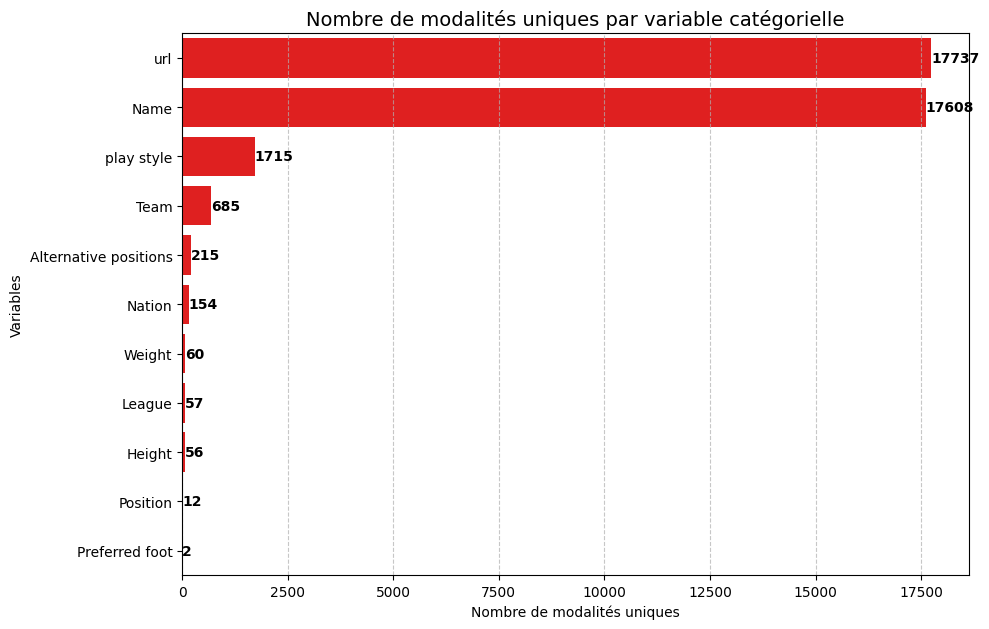

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


cardinality = fifa[cat_col].nunique().sort_values(ascending=False)

# Création du graphique
plt.figure(figsize=(10, len(cat_col) * 0.4 + 2)) 

# Code couleur : Rouge pour cardinalité élevée (>50), Bleu pour le reste
colors = ['red' if x > 50 else 'skyblue' for x in cardinality.values]

ax = sns.barplot(x=cardinality.values, y=cardinality.index, palette=colors)

# Ajout des étiquettes de valeur (le nombre exact) au bout des barres
for i, v in enumerate(cardinality.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.title('Nombre de modalités uniques par variable catégorielle', fontsize=14)
plt.xlabel('Nombre de modalités uniques')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

* Seules les variales Position et Preferred foot sont des variables catégorielles pertientes pour notre analyse.

* Les variables Height, Weight sont des variables numériques.

* Vérifier si les noms ne sont pas doublés



In [9]:
mask_dups = fifa["Name"].duplicated(keep=False)
dups = fifa[mask_dups]
dups_sorted = dups.sort_values("Name", ascending=False)
display(dups_sorted[["Name", "Position"]])
 

,Name,Position
5088,Óscar Gil,RB
10094,Óscar Gil,CB
14337,Ángel González,GK
12705,Ángel González,RM
5452,Zé Carlos,RB
...,...,...
1648,Adama Traoré,RM
3026,Aarón,LB
1812,Aarón,GK
4578,Aaron Ramsey,LM


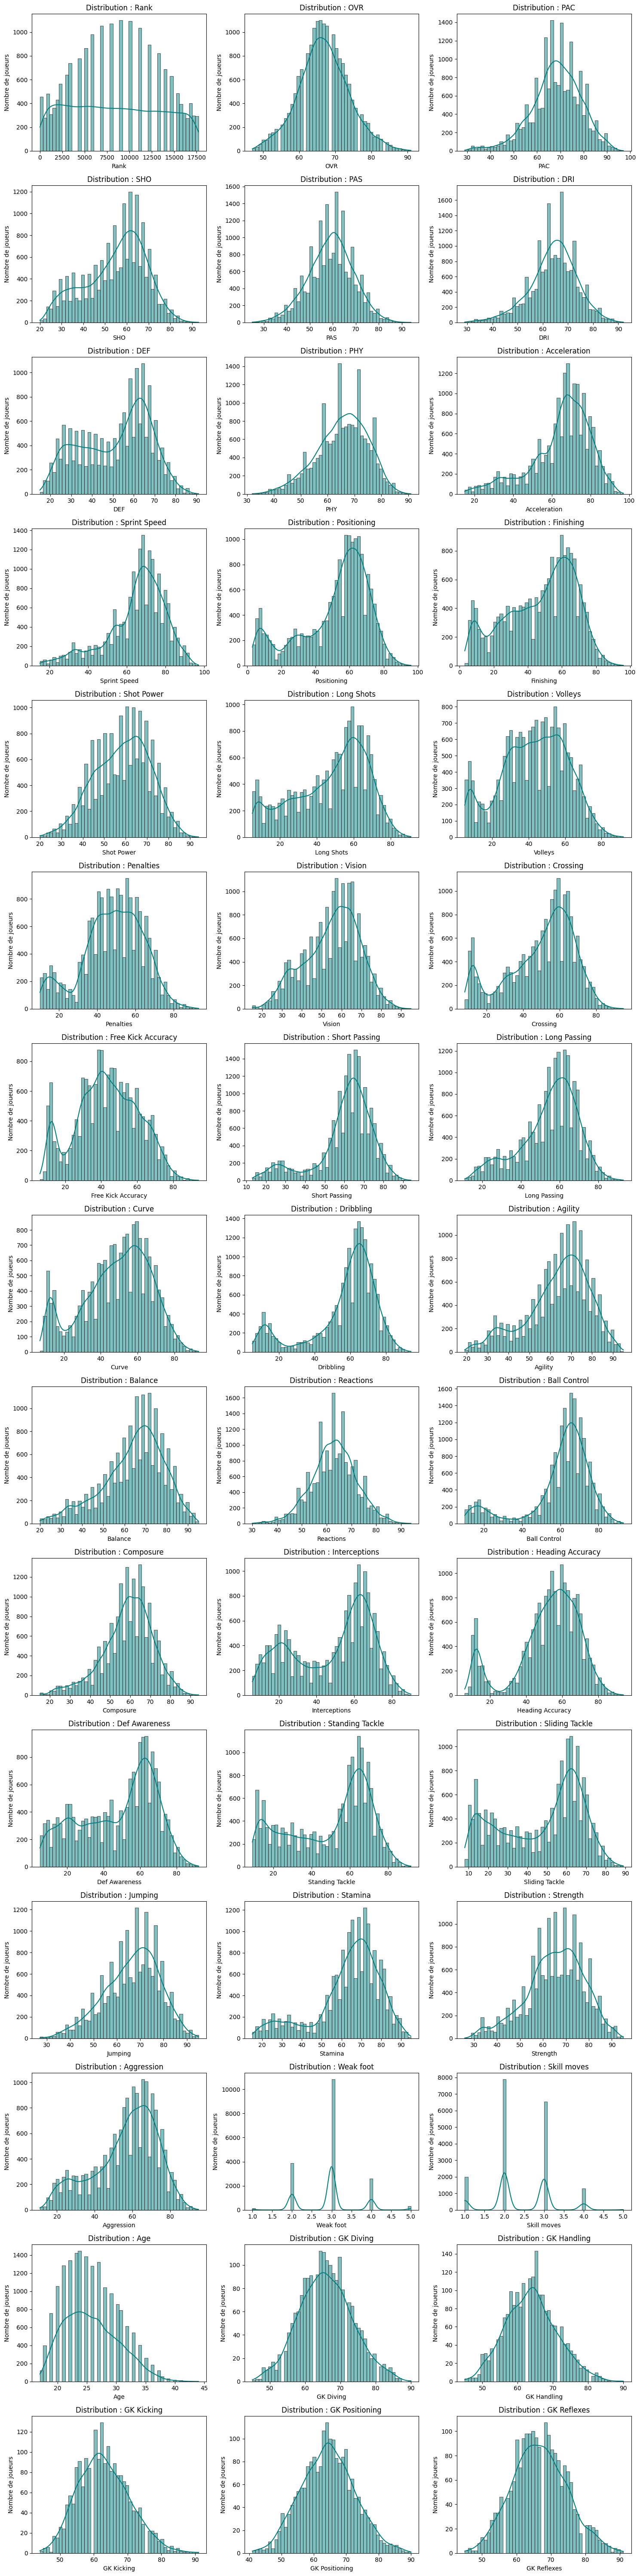

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import math


n_cols_plot = 3
n_rows_plot = math.ceil(len(num_col) / n_cols_plot)

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 4 * n_rows_plot))
axes = axes.flatten() 

for i, col in enumerate(num_col):
    
    sns.histplot(fifa[col], bins=50, kde=True, ax=axes[i], color='teal')
    
    axes[i].set_title(f'Distribution : {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Nombre de joueurs')

for i in range(len(num_col), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

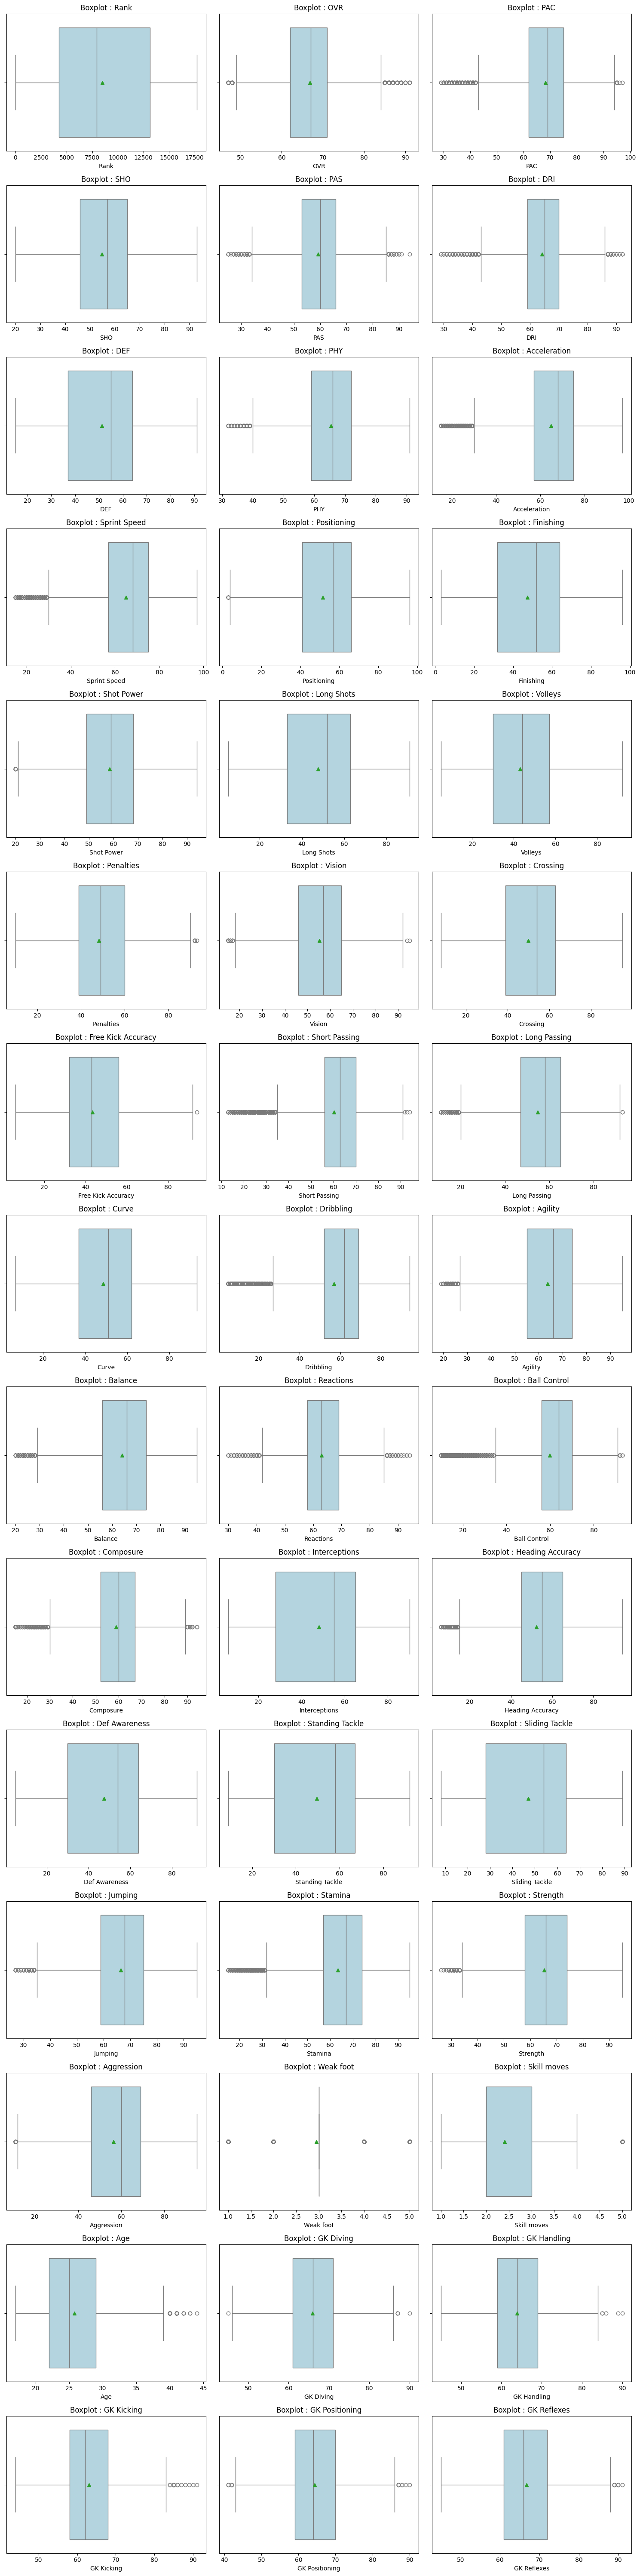

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

n_cols_plot = 3
n_rows_plot = math.ceil(len(num_col) / n_cols_plot)

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 4 * n_rows_plot))
axes = axes.flatten()

for i, col in enumerate(num_col):

    sns.boxplot(x=fifa[col], ax=axes[i], color='lightblue', showmeans=True)
    
    axes[i].set_title(f'Boxplot : {col}')
    axes[i].set_xlabel(col)

for i in range(len(num_col), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 3. ENTRAINMENT ET EVALUATION DU MODELE

## 3.1 preprocessing des données

## 3.1.1 Traîtement de "play style" et "Alternative positions"

In [11]:

complex_cols = ['Alternative positions', 'play style']

for col in complex_cols:
    if col in fifa.columns:
        print(f"--- Analyse des modalités pour : {col} ---")
        
        all_modalities = fifa[col].dropna().astype(str).str.split(',').explode().str.strip()
        

        counts = all_modalities.value_counts()
        
        print(f"Nombre de modalités uniques trouvées : {len(counts)}")
        print("Les 10 plus fréquentes :")
        print(counts.head(10))
        print("\nToutes les modalités :")
        print(counts.index.tolist())
        print("\n" + "="*50 + "\n")
    else:
        print(f"Attention : La colonne '{col}' n'a pas été trouvée dans le DataFrame.")

--- Analyse des modalités pour : Alternative positions ---
Nombre de modalités uniques trouvées : 11
Les 10 plus fréquentes :
Alternative positions
CM     2101
RM     1749
LM     1732
LW     1545
RW     1452
CDM    1394
CAM    1252
ST      780
RB      753
LB      735
Name: count, dtype: int64

Toutes les modalités :
['CM', 'RM', 'LM', 'LW', 'RW', 'CDM', 'CAM', 'ST', 'RB', 'LB', 'CB']


--- Analyse des modalités pour : play style ---
Nombre de modalités uniques trouvées : 68
Les 10 plus fréquentes :
play style
Technical         1471
Long Ball Pass    1180
Rapid             1169
Flair             1144
Slide Tackle       766
Aerial             745
Power Header       665
Finesse Shot       645
Intercept          624
Block              568
Name: count, dtype: int64

Toutes les modalités :
['Technical', 'Long Ball Pass', 'Rapid', 'Flair', 'Slide Tackle', 'Aerial', 'Power Header', 'Finesse Shot', 'Intercept', 'Block', 'Anticipate', 'Bruiser', 'Relentless', 'Incisive Pass', 'Jockey', 'Quick St

In [12]:
def one_hot_encode_list_column(df, col_name, separator=','):
    clean_series = df[col_name].fillna('').astype(str).str.replace(' ', '')

    dummies = clean_series.str.get_dummies(sep=separator)

    dummies = dummies.add_prefix(f"{col_name}_")
    df_result = pd.concat([df, dummies], axis=1)
    
    return df_result


ALTP = one_hot_encode_list_column(fifa, 'play style')

ALTP.head(10)


,Rank,Name,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,...,play style_Technical,play style_Technical+,play style_TikiTaka,play style_TikiTaka+,play style_Trickster,play style_Trickster+,play style_Trivela,play style_Trivela+,play style_WhippedPass,play style_WhippedPass+
0,1,Kylian Mbappé,91,97,90,80,92,36,78,97,...,0,0,0,0,0,0,1,0,0,0
1,2,Rodri,91,66,80,86,84,87,85,65,...,0,0,0,1,0,0,0,0,0,0
2,4,Erling Haaland,91,88,92,70,81,45,88,80,...,0,0,0,0,0,0,0,0,0,0
3,5,Jude Bellingham,90,80,87,83,88,78,83,81,...,1,0,0,0,0,0,0,0,0,0
4,7,Vini Jr.,90,95,84,81,91,29,69,95,...,0,0,0,0,0,0,1,0,0,0
5,9,Kevin De Bruyne,90,67,87,94,87,65,78,67,...,0,0,0,0,0,0,1,0,1,0
6,11,Harry Kane,90,65,93,84,83,49,82,64,...,0,0,0,0,0,0,1,0,0,0
7,12,Martin Ødegaard,89,70,82,89,89,67,66,72,...,1,0,0,0,0,0,1,0,1,0
8,13,Gianluigi Donnarumma,89,90,84,73,90,52,87,50,...,0,0,0,0,0,0,0,0,0,0
9,15,Alisson,89,86,85,85,89,56,90,60,...,0,0,0,0,0,0,0,0,0,0


## 3.2 Création du modèle

### 3.2.1 Modèle 1.0 (KNN)

On utilise que les colonnes numériques pour ce modèle

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
 
y = fifa[["Position"]]
X = fifa.iloc[:,2:41].drop(columns=["Position"])
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
cross_values = []
n_neighbors_values = []
 
for i in range(1, 35) :
    model = KNeighborsClassifier(n_neighbors=i)
    model_fit = model.fit(X_train,y_train)
    cross_value = cross_val_score(model_fit, X_train, y_train)
    cross_values.append(cross_value.mean())
    n_neighbors_values.append(i)
 
best_idx = np.argmax(cross_values)
best_n_neighbors = n_neighbors_values[best_idx]
best_score = cross_values[best_idx]

plt.figure(figsize=(10,5))
plt.plot(n_neighbors_values,cross_values)
plt.xticks(np.arange(min(n_neighbors_values), max(n_neighbors_values)+1, 1.0))
print(f"Best neighbors : {best_n_neighbors}, Score : {best_score}")
plt.show()

/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

KeyboardInterrupt: 

/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:243: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

0.6659384460304201


<Figure size 3000x3000 with 0 Axes>

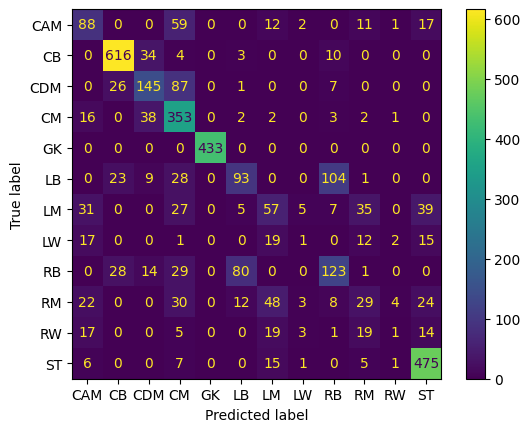

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
 
model = KNeighborsClassifier(n_neighbors=29)
model_fit = model.fit(X_train,y_train)
cross_value = cross_val_score(model_fit, X_train, y_train)
print(cross_value.mean())
 
y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)
model.score(X_test,y_test)

plt.figure(figsize=(30,30))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [13]:

def one_hot_encode_list_column(df, col_name, separator=','):
    clean_series = df[col_name].fillna('').astype(str).str.replace(' ', '')

    dummies = clean_series.str.get_dummies(sep=separator)

    dummies = dummies.add_prefix(f"{col_name}_")
    df_result = pd.concat([df, dummies], axis=1)
    
    return df_result

In [14]:
import pandas as pd
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score


y = fifa['Position'].copy()

# Colonnes à supprimer (non pertinentes ou non atomiques)
cols_to_drop = ["url", "GK Diving", "GK Handling", "GK Kicking", "GK Positioning", 
                "GK Reflexes", 'Name', 'Nation', 
                'League', 'Team', 'Rank', 'Position']

fifa_cleaned = fifa.drop(columns=cols_to_drop)

# Nettoyage de Height et Weight
fifa_cleaned["Height"] = fifa["Height"].str.extract(r'(\d+)').astype(int)
fifa_cleaned["Weight"] = fifa["Weight"].str.extract(r'(\d+)').astype(int)
fifa_cleaned = one_hot_encode_list_column(fifa_cleaned, 'play style')
fifa_cleaned = one_hot_encode_list_column(fifa_cleaned, 'Alternative positions')
fifa_cleaned = fifa_cleaned.drop(columns= ['play style', 'Alternative positions'])

numerical_selector = make_column_selector(dtype_include=['number'])
categorical_selector = make_column_selector(dtype_include=['object', 'category'])

num_features = numerical_selector(fifa_cleaned)
cat_features = categorical_selector(fifa_cleaned)


X = fifa_cleaned[num_features + cat_features].copy()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train


,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,...,Alternative positions_CDM,Alternative positions_CM,Alternative positions_LB,Alternative positions_LM,Alternative positions_LW,Alternative positions_RB,Alternative positions_RM,Alternative positions_RW,Alternative positions_ST,Preferred foot
12627,61,60,63,57,60,29,59,30,28,4,...,0,0,0,0,0,0,0,0,0,Left
5996,68,57,48,61,59,67,73,54,59,50,...,0,0,0,0,0,0,0,0,0,Left
1983,74,85,67,63,79,24,62,88,82,70,...,0,0,0,0,0,0,1,0,1,Left
15845,52,66,45,48,53,25,59,65,66,52,...,0,0,0,0,1,0,0,0,0,Right
7391,67,55,38,50,58,67,67,54,55,46,...,0,0,0,0,0,0,0,0,0,Right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,63,61,54,65,65,57,49,64,58,53,...,1,0,0,0,0,0,0,0,0,Left
11964,62,68,58,59,63,54,68,70,67,58,...,1,0,0,0,0,0,0,0,0,Right
5390,69,79,42,61,62,64,79,76,82,59,...,0,0,0,0,0,0,0,0,0,Right
860,77,72,77,65,72,30,67,69,74,83,...,0,0,0,0,0,0,0,0,0,Right


In [15]:
# Définition du Preprocessor et Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])



In [16]:
# Cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Scores Accuracy par fold: {cv_scores}")
print(f"Accuracy moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Scores Accuracy par fold: [0.8012685  0.80831572 0.80232558 0.80408739 0.79696863]
Accuracy moyenne: 0.8026 (+/- 0.0037)


In [17]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score Accuracy: {grid_search.best_score_:.4f}")
grid_search

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 409, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 96, in _cached_call
   

Meilleurs paramètres: {'model__metric': 'manhattan', 'model__n_neighbors': 11, 'model__weights': 'distance'}
Meilleur score Accuracy: 0.8614


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__metric': ['euclidean', 'manhattan'], 'model__n_neighbors': [3, 5, ...], 'model__weights': ['uniform', 'distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and par

In [18]:
from sklearn.linear_model import SGDClassifier

pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(random_state=42, max_iter=1000))
])

cv_scores = cross_val_score(pipeline2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Scores Accuracy par fold: {cv_scores}")
print(f"Accuracy moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Scores Accuracy par fold: [0.90204369 0.91014799 0.91472868 0.91120507 0.90130419]
Accuracy moyenne: 0.9079 (+/- 0.0053)


In [19]:
param_grid2 = {
    'model__loss': ['hinge', 'log_loss', 'modified_huber'],  # 'hinge' = SVM linéaire, 'log_loss' = Régression logistique
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],              #
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__learning_rate': ['constant', 'optimal', 'adaptive'],
    'model__eta0': [0.01, 0.1]                               # Taux d'apprentissage initial
}
grid_search2 = GridSearchCV(pipeline2, param_grid2, cv=5, scoring='accuracy', n_jobs=-1)
grid_search2.fit(X_train, y_train)
print("--- SGD Classifier ---")
print(f"Meilleurs paramètres: {grid_search2.best_params_}")
print(f"Meilleur score Accuracy: {grid_search2.best_score_:.4f}")

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic

--- SGD Classifier ---
Meilleurs paramètres: {'model__alpha': 0.001, 'model__eta0': 0.1, 'model__learning_rate': 'adaptive', 'model__loss': 'modified_huber', 'model__penalty': 'l1'}
Meilleur score Accuracy: 0.9216


In [20]:
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# Meilleur modèle
best_model = grid_search2.best_estimator_

# Prédiction sur les données de test
y_pred = best_model.predict(X_test)
print(f"accuracy: {best_model.score(X_test, y_test)}")
best_model

accuracy: 0.9258737316798196


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

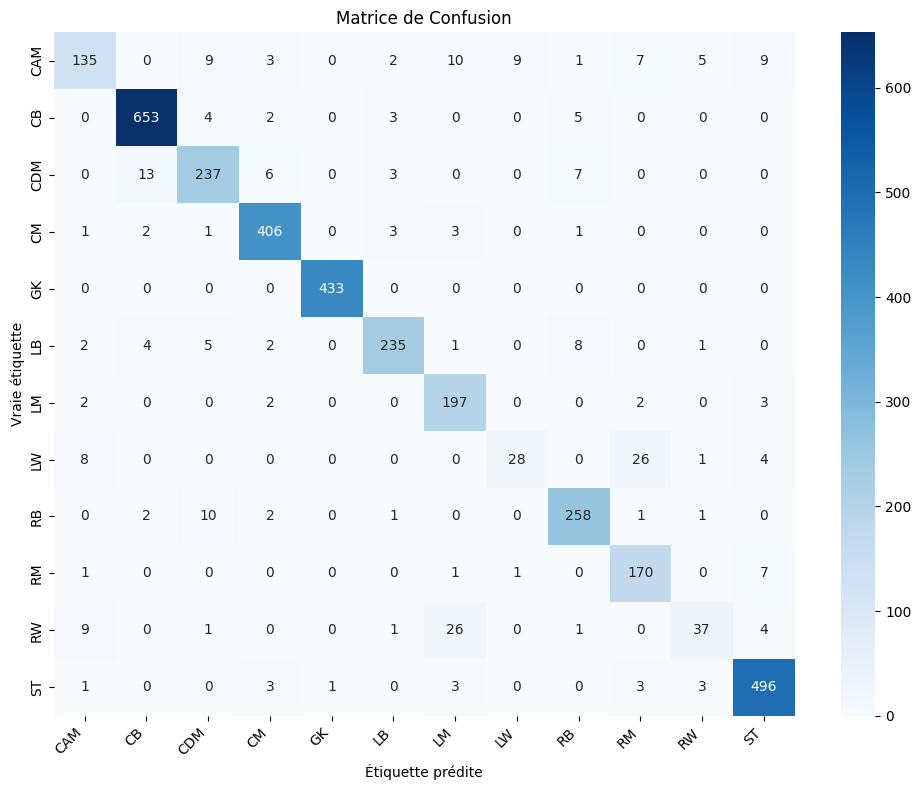

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

class_names = best_model.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names, 
    yticklabels=class_names   
)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import classification_report
import pandas as pd

# output_dict=True pour avoir un dictionnaire convertible en DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Arrondir pour la lisibilité
report_df = report_df.round(2)

print(report_df)

# Trier par Recall décroissant pour voir les classes problématiques
print("\n--- Triées par Recall (plus faible en premier) ---")
report_df.iloc[:-3].sort_values(by='recall')

              precision  recall  f1-score  support
CAM                0.85    0.71      0.77   190.00
CB                 0.97    0.98      0.97   667.00
CDM                0.89    0.89      0.89   266.00
CM                 0.95    0.97      0.96   417.00
GK                 1.00    1.00      1.00   433.00
LB                 0.95    0.91      0.93   258.00
LM                 0.82    0.96      0.88   206.00
LW                 0.74    0.42      0.53    67.00
RB                 0.92    0.94      0.93   275.00
RM                 0.81    0.94      0.87   180.00
RW                 0.77    0.47      0.58    79.00
ST                 0.95    0.97      0.96   510.00
accuracy           0.93    0.93      0.93     0.93
macro avg          0.88    0.85      0.86  3548.00
weighted avg       0.92    0.93      0.92  3548.00

--- Triées par Recall (plus faible en premier) ---


,precision,recall,f1-score,support
LW,0.74,0.42,0.53,67.0
RW,0.77,0.47,0.58,79.0
CAM,0.85,0.71,0.77,190.0
CDM,0.89,0.89,0.89,266.0
LB,0.95,0.91,0.93,258.0
RB,0.92,0.94,0.93,275.0
RM,0.81,0.94,0.87,180.0
LM,0.82,0.96,0.88,206.0
CM,0.95,0.97,0.96,417.0
ST,0.95,0.97,0.96,510.0


# Analyse des performances par classe

## 🔴 Classes problématiques (Recall < 50%)

| Classe | Recall | Diagnostic |
|--------|--------|------------|
| LW | 42% | Plus de la moitié des ailiers gauches sont mal classés |
| RW | 47% | Même problème pour les ailiers droits |

## 🟡 Classes moyennes (Recall 70-95%)

| Classe | Recall | Note |
|--------|--------|------|
| CAM | 71% | Confondu avec d'autres milieux offensifs |
| CDM | 89% | Parfois pris pour CB |
| LB | 91% | Correcte dans l'ensemble |
| RM | 94% | Correcte dans l'ensemble |


## 🟢 Classes excellentes (Recall ≥ 95%)

| Classe | Recall | Pourquoi ? |
|--------|--------|------------|
| GK | 100% | Stats uniques (arrêts, plongeons, etc.) |
| CB | 98% | Profil défensif très marqué |
| ST | 97% | Stats d'attaque/finition distinctes |
| CM | 97% | Position centrale bien définie |
| RB | 96% | Position centrale bien définie |
| LM | 96% | Position centrale bien définie |

### Hypothèse 1 : Biais de déséquilibre des classes

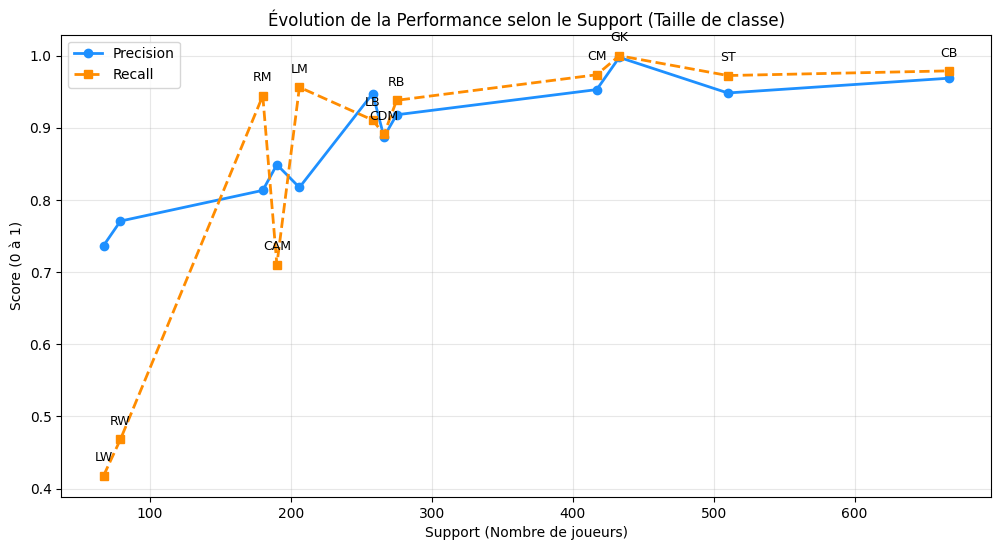

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


report_dict = classification_report(y_test, y_pred, output_dict=True)
df_metrics = pd.DataFrame(report_dict).transpose()


df_metrics = df_metrics.iloc[:-3]
df_sorted = df_metrics.sort_values(by='support')


plt.figure(figsize=(12, 6))
# Courbe Precision
plt.plot(df_sorted['support'], df_sorted['precision'], 
         marker='o', linestyle='-', color='dodgerblue', label='Precision', linewidth=2)

# Courbe Recall
plt.plot(df_sorted['support'], df_sorted['recall'], 
         marker='s', linestyle='--', color='darkorange', label='Recall', linewidth=2)

plt.title('Évolution de la Performance selon le Support (Taille de classe)')
plt.xlabel('Support (Nombre de joueurs)')
plt.ylabel('Score (0 à 1)')
plt.legend()
plt.grid(True, alpha=0.3)

for idx, row in df_sorted.iterrows():
    plt.text(row['support'], row['recall'] + 0.02, idx, fontsize=9, ha='center')

plt.show()

### Hypothèse 2 : Similitude entre certaines classes

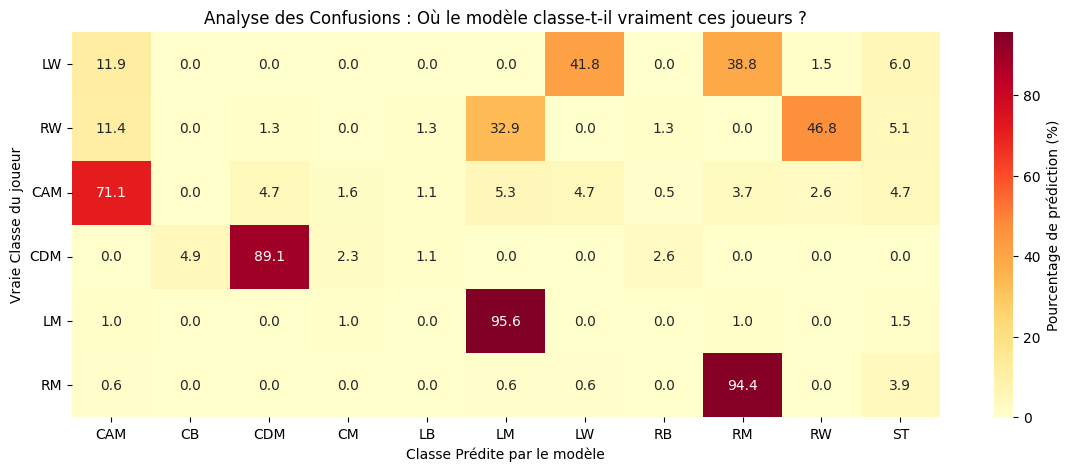

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

classes = best_model.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Normalisation par ligne
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Création d'un DataFrame pour manipuler facilement
df_cm = pd.DataFrame(cm_pct, index=classes, columns=classes)

target_rows = ['LW', 'RW', 'CAM', 'CDM', 'LM', 'RM']
df_focused = df_cm.loc[target_rows]

cols_active = df_focused.columns[(df_focused > 1).any()]
df_focused = df_focused[cols_active]

# Heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(df_focused, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Pourcentage de prédiction (%)'})

plt.title('Analyse des Confusions : Où le modèle classe-t-il vraiment ces joueurs ?')
plt.xlabel('Classe Prédite par le modèle')
plt.ylabel('Vraie Classe du joueur')
plt.yticks(rotation=0)
plt.show()

/var/folders/lh/9q5zb88s3597k4f9dr4r0zj40000gn/T/ipykernel_60174/356362392.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Position', y='Weak foot', data=wingers, palette='Set1', ax=ax[1])


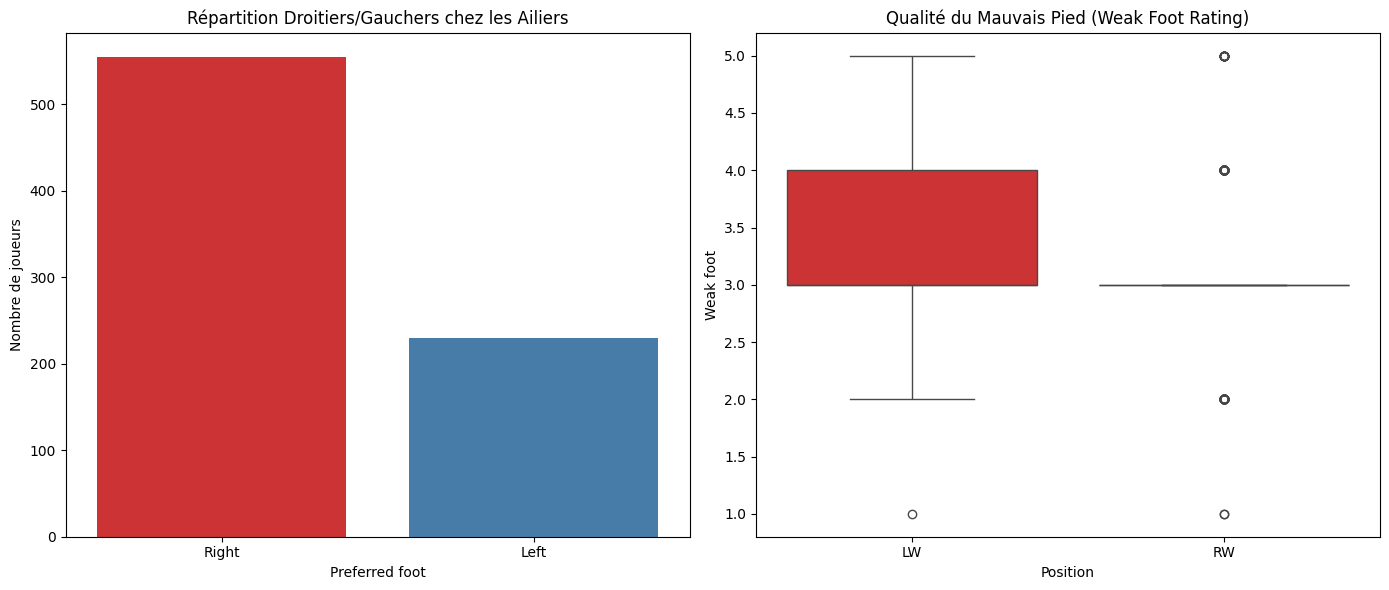

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer uniquement les ailiers
wingers = fifa[fifa['Position'].isin(['LW', 'RW'])]

# Création de la figure avec 2 sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Nombre de Droitiers/Gauchers
sns.countplot(x='Preferred foot', hue='Preferred foot', data=wingers, palette='Set1', ax=ax[0])
ax[0].set_title('Répartition Droitiers/Gauchers chez les Ailiers')
ax[0].set_ylabel('Nombre de joueurs')

# Distribution de la note "Weak foot" (Mauvais pied)
sns.boxplot(x='Position', y='Weak foot', data=wingers, palette='Set1', ax=ax[1])
ax[1].set_title('Qualité du Mauvais Pied (Weak Foot Rating)')

plt.tight_layout()
plt.show()

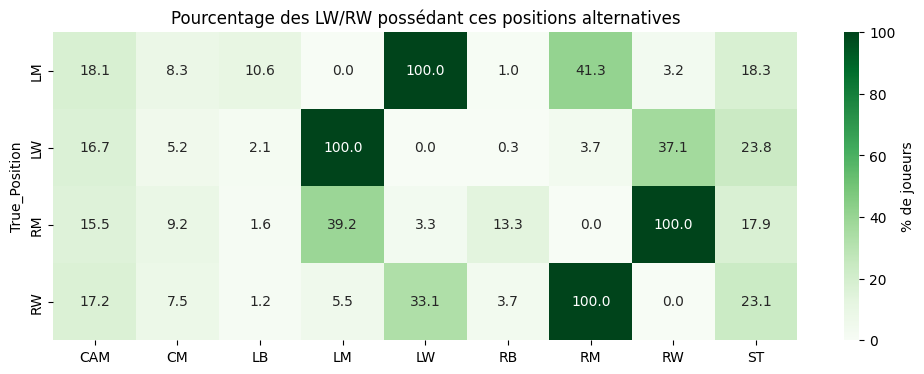

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

analysis_df = X.copy()
analysis_df['True_Position'] = y 

wingers_df = analysis_df[analysis_df['True_Position'].isin(['LW', 'RW', 'LM', 'RM'])]


alt_cols = [c for c in X.columns if 'Alternative positions_' in c]

# Groupement par vraie position et moyenne des alternatives
heatmap_data = wingers_df.groupby('True_Position')[alt_cols].mean() * 100
heatmap_data = heatmap_data.loc[:, (heatmap_data > 5).any(axis=0)]
heatmap_data.columns = [c.replace('Alternative positions_', '') for c in heatmap_data.columns]

# Visualisation
plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label': '% de joueurs'})
plt.title('Pourcentage des LW/RW possédant ces positions alternatives')
plt.show()

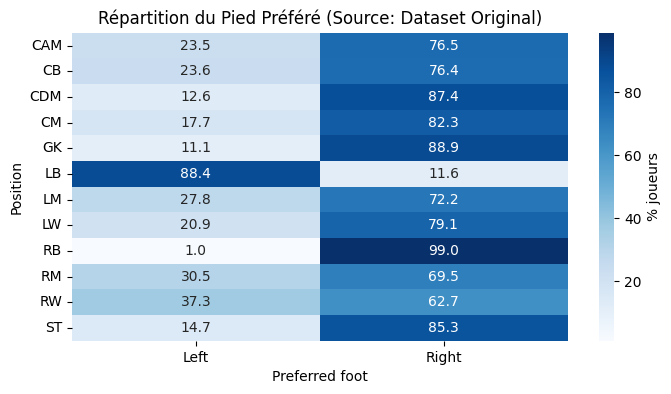

In [57]:
# Méthode "Back to basics" avec le dataset d'origine (beaucoup plus simple si X n'a pas de colonnes nommées)
df_wingers = fifa[fifa['Position'].isin(['LW', 'RW'])]

# Tableau croisé (Crosstab) normalisé en pourcentage
ct = pd.crosstab(fifa['Position'], fifa['Preferred foot'], normalize='index') * 100

plt.figure(figsize=(8, 4))
sns.heatmap(ct, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': '% joueurs'})
plt.title('Répartition du Pied Préféré (Source: Dataset Original)')
plt.show()

#### Test ANOVA

In [59]:
import pandas as pd
from scipy.stats import f_oneway

# Sélection classes cibles
target_classes = ['LW', 'RW', 'LM', 'RM']
df_subset = fifa[fifa['Position'].isin(target_classes)]

# Récupération des colonnes numériques
num_cols = df_subset.select_dtypes(include=['number']).columns.tolist()

results = []

print(f"Test ANOVA pour les classes : {target_classes}")
print("-" * 50)

for col in num_cols:
    groups = [df_subset[df_subset['Position'] == pos][col].dropna() for pos in target_classes]
    
    if all(len(g) > 10 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        results.append({'Variable': col, 'F-Score': f_stat, 'P-Value': p_val})

anova_df = pd.DataFrame(results).sort_values(by='F-Score', ascending=False)

significant_vars = anova_df[anova_df['P-Value'] < 0.05]

print("Top 10 des variables les plus discriminantes (F-Score élevé) :")
print(significant_vars.head(10))

print("\nVariables qui ne permettent PAS de distinguer ces positions (P-Value > 0.05) :")
print(anova_df[anova_df['P-Value'] >= 0.05]['Variable'].tolist())

Test ANOVA pour les classes : ['LW', 'RW', 'LM', 'RM']
--------------------------------------------------
Top 10 des variables les plus discriminantes (F-Score élevé) :
           Variable    F-Score       P-Value
6               DEF  33.143032  4.833478e-21
30    Def Awareness  32.814059  7.747204e-21
28    Interceptions  29.851052  5.454094e-19
32   Sliding Tackle  29.732329  6.468939e-19
31  Standing Tackle  28.583737  3.373802e-18
11        Finishing  12.348040  5.057840e-08
3               SHO   9.402309  3.511750e-06
14          Volleys   8.701652  9.594161e-06
22        Dribbling   8.251664  1.827582e-05
39              Age   7.574423  4.811499e-05

Variables qui ne permettent PAS de distinguer ces positions (P-Value > 0.05) :
['Penalties', 'Agility', 'Long Passing', 'Acceleration', 'Jumping', 'Curve', 'Strength', 'PAC', 'Free Kick Accuracy', 'Vision', 'Sprint Speed', 'Reactions', 'OVR', 'Crossing', 'Balance', 'Heading Accuracy', 'Short Passing', 'Rank', 'PAS']


/var/folders/lh/9q5zb88s3597k4f9dr4r0zj40000gn/T/ipykernel_60174/2284424736.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-Score', y='Variable', data=plot_data, palette=colors)


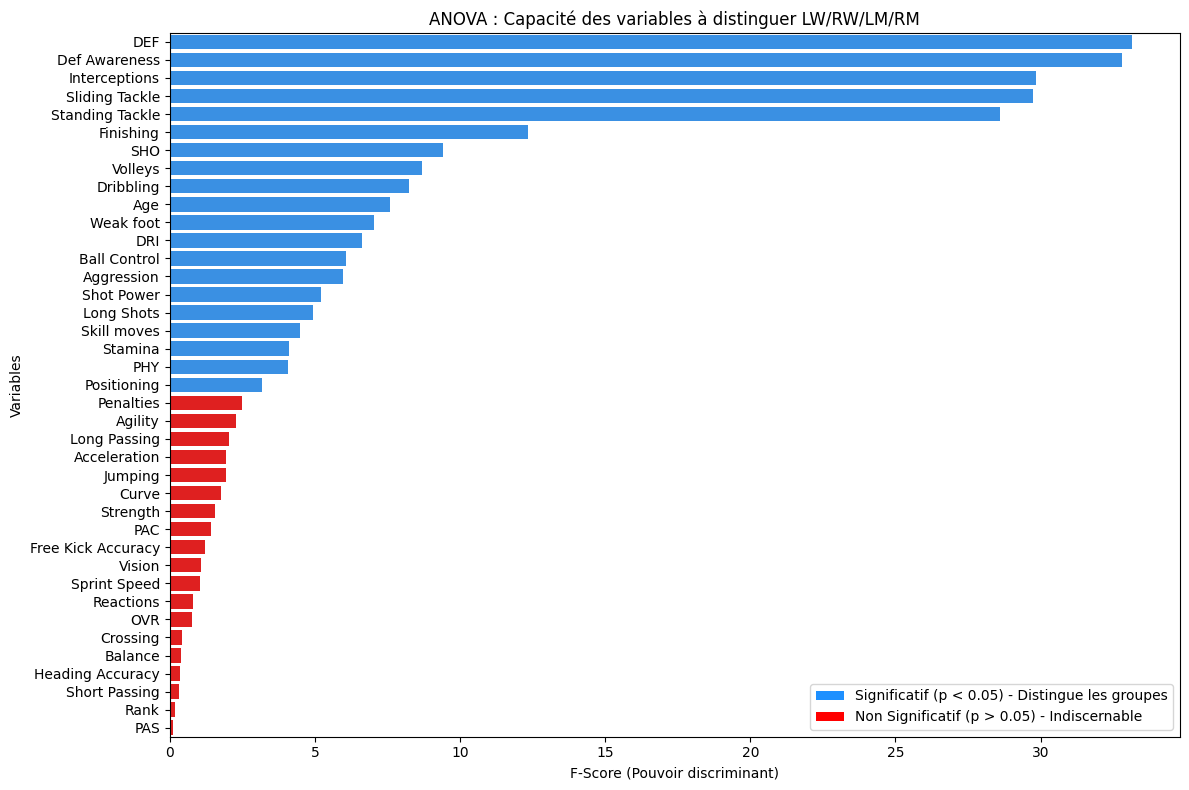

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_vars = anova_df.head(20)
non_sig_vars = anova_df[anova_df['P-Value'] >= 0.05]
plot_data = pd.concat([top_vars, non_sig_vars]).drop_duplicates()

plt.figure(figsize=(12, 8))

colors = ['red' if p > 0.05 else 'dodgerblue' for p in plot_data['P-Value']]

# Barplot du F-Score 
sns.barplot(x='F-Score', y='Variable', data=plot_data, palette=colors)

plt.title("ANOVA : Capacité des variables à distinguer LW/RW/LM/RM")
plt.xlabel("F-Score (Pouvoir discriminant)")
plt.ylabel("Variables")

# Légende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='dodgerblue', label='Significatif (p < 0.05) - Distingue les groupes'),
    Patch(facecolor='red', label='Non Significatif (p > 0.05) - Indiscernable')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

#### Modèle avec StratifiedKFold

In [65]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

kfold = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)

pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(random_state=42, max_iter=1000))
])

# Utilisation du kfold
cv_scores = cross_val_score(pipeline2, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"Scores Accuracy par fold: {cv_scores}")
print(f"Accuracy moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Scores Accuracy par fold: [0.90701606 0.91377853 0.90194421 0.92223161 0.91293322 0.89593909
 0.91539763 0.92470389 0.91624365 0.8891709  0.90693739 0.90947547]
Accuracy moyenne: 0.9096 (+/- 0.0198)


### Modèle avec équilibrage des classes

In [67]:
# Création du pipeline avec class_weight='balanced'
pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(
        loss='modified_huber',       
        alpha=0.001, 
        penalty='l1', 
        learning_rate='adaptive', 
        eta0=0.1,
        class_weight='balanced',    
        random_state=42, 
        max_iter=1000
    ))
])

# Entraînement
print("Entraînement avec pondération des classes...")
pipeline_balanced.fit(X_train, y_train)

# Évaluation
print(f"accuracy: {pipeline_balanced.score(X_test, y_test)}")
y_pred_balanced = pipeline_balanced.predict(X_test)

print("\n--- RAPPORT AVEC class_weight='balanced' ---")
print(classification_report(y_test, y_pred_balanced))



Entraînement avec pondération des classes...
accuracy: 0.9239007891770011

--- RAPPORT AVEC class_weight='balanced' ---
              precision    recall  f1-score   support

         CAM       0.87      0.72      0.79       190
          CB       0.98      0.97      0.97       667
         CDM       0.90      0.91      0.90       266
          CM       0.95      0.97      0.96       417
          GK       1.00      1.00      1.00       433
          LB       0.94      0.92      0.93       258
          LM       0.83      0.93      0.87       206
          LW       0.58      0.61      0.59        67
          RB       0.89      0.94      0.92       275
          RM       0.82      0.91      0.86       180
          RW       0.70      0.61      0.65        79
          ST       0.97      0.94      0.95       510

    accuracy                           0.92      3548
   macro avg       0.87      0.87      0.87      3548
weighted avg       0.92      0.92      0.92      3548



### Fusion des classes latérales

In [74]:
# 1. Définition du dictionnaire
position_mapping = {
    'LW': 'Winger', 'RW': 'Winger', 
    'LM': 'Winger', 'RM': 'Winger'
}

y_grouped = y.replace(position_mapping)

# Vérifications
print("Nouvelles classes :")
print(y_grouped.unique())

print("\nDistribution :")
print(y_grouped.value_counts())
print(f"\nNombre de NaN restants : {y_grouped.isna().sum()}")

Nouvelles classes (plus de NaN espérés) :
['ST' 'CDM' 'CAM' 'Winger' 'CM' 'GK' 'CB' 'LB' 'RB']

Distribution :
Position
CB        3185
Winger    2781
ST        2425
CM        2139
GK        1999
CDM       1447
RB        1404
LB        1333
CAM       1024
Name: count, dtype: int64

Nombre de NaN restants : 0


In [82]:
groups_to_merge = {}
for old_pos, new_pos in position_mapping.items():
    groups_to_merge.setdefault(new_pos, []).append(old_pos)
# 2. Itération et fusion dans le DataFrame X
print("--- Fusion des colonnes dans X ---")
for new_group, old_positions in groups_to_merge.items():
    # On construit les noms de colonnes exacts dans X (ex: 'Alternative positions_LW')
    target_cols = [f"Alternative positions_{pos}" for pos in old_positions]
    
    # On vérifie lesquelles existent vraiment dans X (pour éviter les erreurs)
    available_cols = [c for c in X.columns if c in target_cols]
    
    if available_cols:
        new_col_name = f"Alternative positions_{new_group}"
        

        X[new_col_name] = X[available_cols].max(axis=1)
        
        # SUPPRESSION des anciennes colonnes
        X.drop(columns=available_cols, inplace=True)
        
        print(f"✅ Fusionné : {available_cols} \n   ---> {new_col_name}")
# Vérification finale
print("\nColonnes restantes (Alternative positions) :")
print([c for c in X.columns if 'Alternative positions_' in c])

--- Fusion des colonnes dans X ---
✅ Fusionné : ['Alternative positions_LM', 'Alternative positions_LW', 'Alternative positions_RM', 'Alternative positions_RW'] 
   ---> Alternative positions_Winger

Colonnes restantes (Alternative positions) :
['Alternative positions_CAM', 'Alternative positions_CB', 'Alternative positions_CDM', 'Alternative positions_CM', 'Alternative positions_LB', 'Alternative positions_RB', 'Alternative positions_ST', 'Alternative positions_Winger']


### Modèle avec les classes latérales fusionnées

In [83]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_grouped, test_size=0.2, random_state=42)
X_train

,OVR,PAC,SHO,PAS,DRI,DEF,PHY,Acceleration,Sprint Speed,Positioning,...,play style_WhippedPass+,Alternative positions_CAM,Alternative positions_CB,Alternative positions_CDM,Alternative positions_CM,Alternative positions_LB,Alternative positions_RB,Alternative positions_ST,Preferred foot,Alternative positions_Winger
12627,61,60,63,57,60,29,59,30,28,4,...,0,0,0,0,0,0,0,0,Left,0
5996,68,57,48,61,59,67,73,54,59,50,...,0,0,0,0,0,0,0,0,Left,0
1983,74,85,67,63,79,24,62,88,82,70,...,0,0,0,0,0,0,0,1,Left,1
15845,52,66,45,48,53,25,59,65,66,52,...,0,0,0,0,0,0,0,0,Right,1
7391,67,55,38,50,58,67,67,54,55,46,...,0,0,0,0,0,0,0,0,Right,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,63,61,54,65,65,57,49,64,58,53,...,0,0,0,1,0,0,0,0,Left,0
11964,62,68,58,59,63,54,68,70,67,58,...,0,1,0,1,0,0,0,0,Right,0
5390,69,79,42,61,62,64,79,76,82,59,...,0,0,1,0,0,0,0,0,Right,0
860,77,72,77,65,72,30,67,69,74,83,...,0,0,0,0,0,0,0,0,Right,0


In [87]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

numerical_selector = make_column_selector(dtype_include=['number'])
categorical_selector = make_column_selector(dtype_include=['object', 'category'])
# 2. Recréation du Preprocessor
preprocessor_updated = ColumnTransformer(
    transformers=[
        # On standardise les variables numériques (y compris les positions OneHot fusionnées)
        ('num', StandardScaler(), numerical_selector),
        # On encode les variables catégorielles restantes (Nation, League...)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_selector)
    ]
)
# 3. Création du Pipeline avec le NOUVEAU preprocessor
pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor_updated),
    ('model', SGDClassifier(random_state=42, max_iter=1000, class_weight='balanced')) 
])

# 4. Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Lancement de la validation croisée sur les données fusionnées...")
cv_scores = cross_val_score(pipeline3, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"\nScores Accuracy par fold: {cv_scores}")
print(f"Accuracy moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Lancement de la validation croisée sur les données fusionnées...

Scores Accuracy par fold: [0.92036646 0.92212826 0.91754757 0.91050035 0.91223123]
Accuracy moyenne: 0.9166 (+/- 0.0090)


In [89]:
pipeline_opti = Pipeline(steps=[
    ('preprocessor', preprocessor_updated),
    ('model', SGDClassifier(
        loss='modified_huber',       
        alpha=0.001, 
        penalty='l1', 
        learning_rate='adaptive', 
        eta0=0.1,
        class_weight='balanced',    
        random_state=42, 
        max_iter=1000
    ))
])

In [90]:
# 4. Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Lancement de la validation croisée sur les données fusionnées...")
cv_scores = cross_val_score(pipeline_opti, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"\nScores Accuracy par fold: {cv_scores}")
print(f"Accuracy moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Lancement de la validation croisée sur les données fusionnées...

Scores Accuracy par fold: [0.92248062 0.93234672 0.92142354 0.92459479 0.92774057]
Accuracy moyenne: 0.9257 (+/- 0.0079)


In [91]:
pipeline_opti.fit(X_train, y_train)
# Prédiction sur les données de test
y_pred = pipeline_opti.predict(X_test)
print(f"accuracy: {pipeline_opti.score(X_test, y_test)}")
pipeline_opti

accuracy: 0.9306651634723788


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

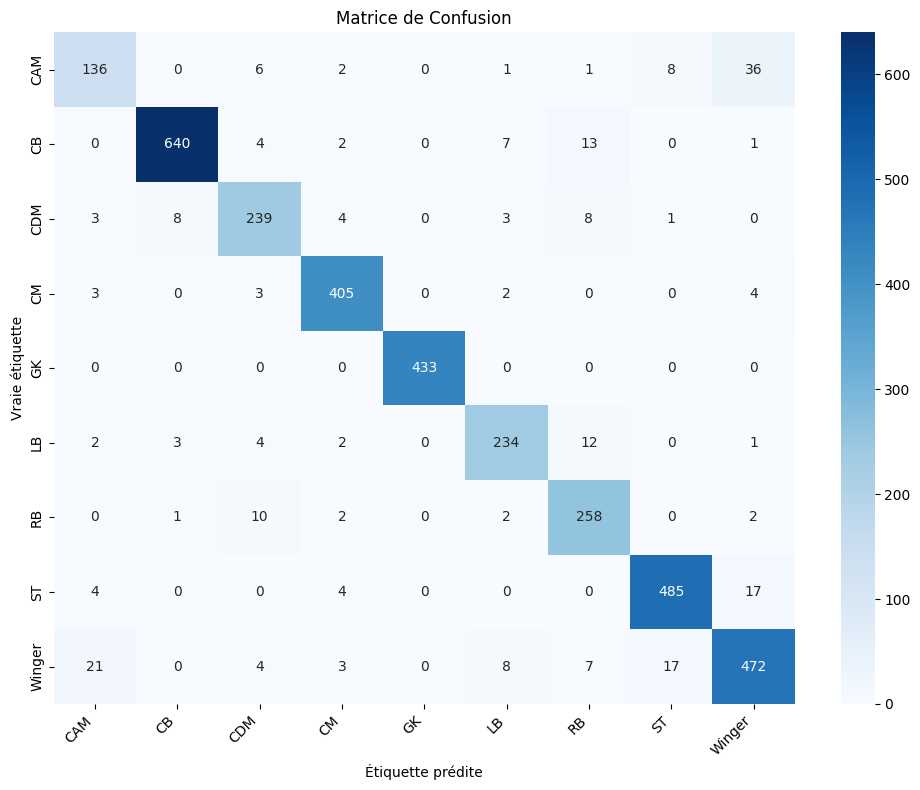

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

class_names = pipeline_opti.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names, 
    yticklabels=class_names   
)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import classification_report
import pandas as pd

# output_dict=True pour avoir un dictionnaire convertible en DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Arrondir pour la lisibilité
report_df = report_df.round(2)

print(report_df)

# Trier par Recall décroissant pour voir les classes problématiques
print("\n--- Triées par Recall (plus faible en premier) ---")
report_df.iloc[:-3].sort_values(by='recall')

              precision  recall  f1-score  support
CAM                0.80    0.72      0.76   190.00
CB                 0.98    0.96      0.97   667.00
CDM                0.89    0.90      0.89   266.00
CM                 0.96    0.97      0.96   417.00
GK                 1.00    1.00      1.00   433.00
LB                 0.91    0.91      0.91   258.00
RB                 0.86    0.94      0.90   275.00
ST                 0.95    0.95      0.95   510.00
Winger             0.89    0.89      0.89   532.00
accuracy           0.93    0.93      0.93     0.93
macro avg          0.91    0.91      0.91  3548.00
weighted avg       0.93    0.93      0.93  3548.00

--- Triées par Recall (plus faible en premier) ---


,precision,recall,f1-score,support
CAM,0.80,0.72,0.76,190.0
Winger,0.89,0.89,0.89,532.0
CDM,0.89,0.90,0.89,266.0
LB,0.91,0.91,0.91,258.0
RB,0.86,0.94,0.90,275.0
ST,0.95,0.95,0.95,510.0
CB,0.98,0.96,0.97,667.0
CM,0.96,0.97,0.96,417.0
GK,1.00,1.00,1.00,433.0


In [79]:
param_grid3 = {
    'model__loss': ['hinge', 'log_loss', 'modified_huber'],  
    'model__alpha': [0.0001, 0.001, 0.01, 0.1],              
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__learning_rate': ['constant', 'optimal', 'adaptive'],
    'model__eta0': [0.01, 0.1]                               
}
grid_search3 = GridSearchCV(pipeline2, param_grid2,cv=kfold, scoring='accuracy', n_jobs=-1)
grid_search3.fit(X_train, y_train)
print("--- SGD Classifier ---")
print(f"Meilleurs paramètres: {grid_search2.best_params_}")
print(f"Meilleur score Accuracy: {grid_search2.best_score_:.4f}")

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic

KeyboardInterrupt: 

# 4. TEST DU MODELE